In [1]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,naive_bayes,preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Negative":
            y.values[i]=0.0
        elif y[i]=="Positive":
            y.values[i]=1.0
        else:
            y.values[i]=2.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

In [4]:
with open("All_Tickers.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")
print("Number of Examples : ",len(X))
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")
X.to_csv (r'Tech.csv', index = False, header=True)

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n")

y=target_arrange(X['Target'])

print("Negative Examples : ",(y==0.0).sum())
print("Positive Examples : ",(y==1.0).sum())
print("Neutral Examples : ", (y==2.0).sum())





Number of Examples :  28680
Number of Examples after removing duplicates:  28478 

Number of words before cleaning :  1086021
Number of words after cleaning :  730700


Negative Examples :  3262
Positive Examples :  10112
Neutral Examples :  15104


In [5]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])

print(X['Article'])

0        vianet group inc announc unaudit second quarte...
1        krato present canaccord virtual growth confer ...
2        rewalk robot report second quarter financi res...
3        pyxi tanker announc date releas second quarter...
4        bionano genom report second quarter financi re...
                               ...                        
28473    latest market buzz market go crazi spac reader...
28474    hubspot surg august digit market softwar compa...
28475    dividend increas expect septemb august anoth e...
28476    jcom final deadlin rosen trust top rank law fi...
28477    virgin galact plan next test spaceflight oct n...
Name: Article, Length: 28478, dtype: object


In [6]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9)
Xv = tfidf_vectorizer.fit_transform(X['Article'])
Xv = pd.DataFrame(Xv.todense())
X_train,X_test,y_train,y_test = train_test_split(Xv,y, test_size=0.25,stratify=y)


Metrics

 Recall metric: 0.684543810551468
 F1 metric: 0.6953353617983508
 Precision metric: 0.7310132575757575
 Accuracy metric: 0.7661516853932584
 Balanced Accuracy metric: 0.684543810551468 

**************************************************

Normalized confusion matrix
[[0.42 0.43 0.15]
 [0.03 0.85 0.12]
 [0.03 0.19 0.79]]


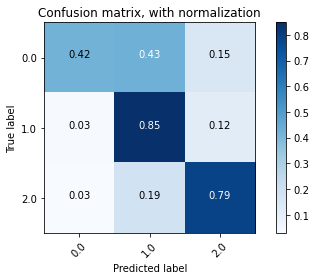

In [7]:
alpha = 0.1 # This is the smoothing parameter for Laplace/Lidstone smoothing
model = naive_bayes.MultinomialNB(alpha=alpha)

model.fit(X_train,y_train)
y_predicted = model.predict(X_test)

print("\nMetrics\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0, 2.0],
                      title='Confusion matrix, with normalization')


In [23]:
skfold = model_selection.StratifiedKFold(n_splits=5,random_state=1)

model2 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
results = model_selection.cross_val_score(model2, Xv,y, cv=skfold,scoring='balanced_accuracy',n_jobs=-1)
print("Balanced Accuracy : ",results.mean())

model2 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
results = model_selection.cross_val_score(model2, Xv,y, cv=skfold,scoring='accuracy',n_jobs=-1)
print("Accuracy : ",results.mean())


Balanced Accuracy :  0.6976117955180147
Accuracy :  0.787958749414864



Metrics

 Recall metric: 0.7264790763083463
 F1 metric: 0.7442182027064833
 Precision metric: 0.8056552296640048
 Accuracy metric: 0.8116573033707866
 Balanced Accuracy metric: 0.7264790763083463 

**************************************************

Normalized confusion matrix
[[0.44 0.43 0.13]
 [0.02 0.91 0.07]
 [0.01 0.16 0.82]]


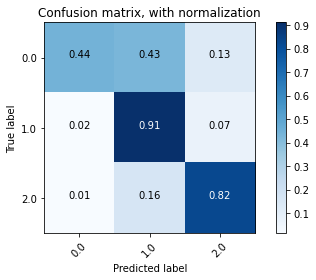

In [8]:
model2 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
model2.fit(X_train,y_train)
y_predicted = model2.predict(X_test)


recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)

print("\nMetrics\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0, 2.0],
                      title='Confusion matrix, with normalization')